# Прогнозирование количества заказов такси

Компания "Чётенькое такси" заказала разработку модели прогнозирования количества заказов такси с 
целью регулирования количества привлекаемых к работе водителей в часы-пик.  
Для формирования модели были предоставлены исторические данные о заказах такси в аэропортах.  

План работы:   
    1) Загрузка данных, их ресэмплирование    
    2) Анализ данных    
    3) Обучение моделей с различными гиперпараметрами: LinearRegression, LGBMRegressor и CatBoostRegressor   
    4) Проверка лучшей модели на тестовой выборке  
    5) Итоги работы  

In [1]:
!pip install shap -q # -q убирает необязательные выводы в командах Linux
!pip install lightgbm
!pip install catboost
!pip install scikit-learn --upgrade

ERROR: Invalid requirement: '#'


In [2]:
#импорт библиотек

import os
import pandas as pd
import numpy as np
import re
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from numpy.random import RandomState
from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import lightgbm
import catboost
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

print(lightgbm.__version__)

4.3.0


### Загрузка данных

In [3]:
#импорт файлов
pd.set_option('display.max_columns', 50) 
pth1_1 = '/datasets/taxi.csv'
pth2_1 = 'taxi.csv'

if os.path.exists(pth1_1):
    taxi= pd.read_csv(pth1_1, index_col=[0], parse_dates=[0], sep=',', decimal=';')
elif os.path.exists(pth2_1):
    taxi = pd.read_csv(pth2_1, index_col=[0], parse_dates=[0], sep=',', decimal=';')
else:
    print('Something is wrong')

In [4]:
display(taxi.head(5))
taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
display(taxi.head(5))
display(taxi.index.min(), taxi.index.max())
display(taxi.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Timestamp('2018-03-01 00:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

Данные из файла taxi.csv были загружены.  
В исходной таблице 26496 записей. 
Было произведено ресемплирование по часу, что сократило таблицу до 4416 записей.

### Анализ данных 

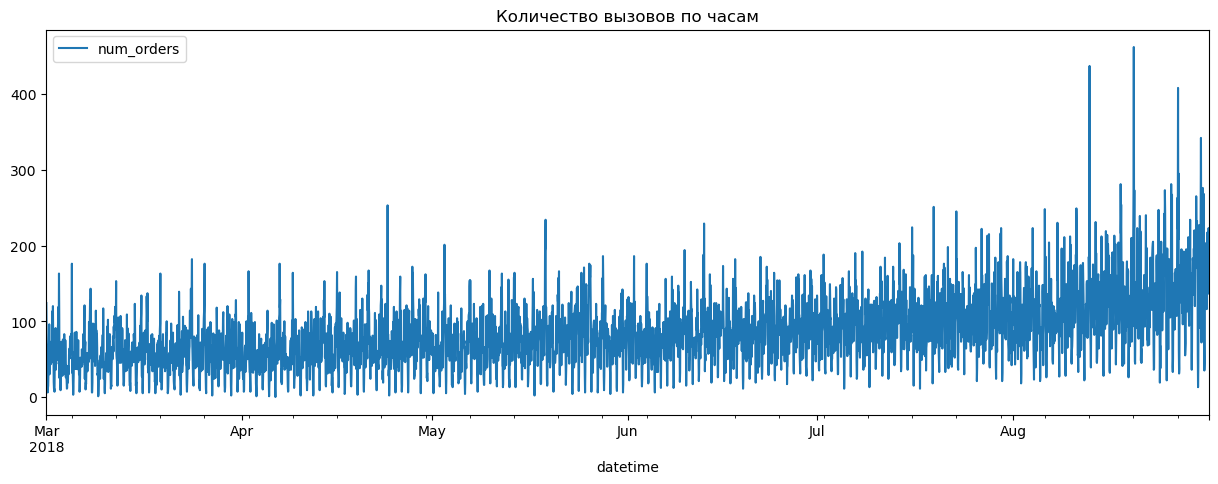

In [6]:
plt.figure(figsize=(15, 5))
plt.title('Количество вызовов по часам')
taxi.plot(ax=plt.gca())


plt.show()

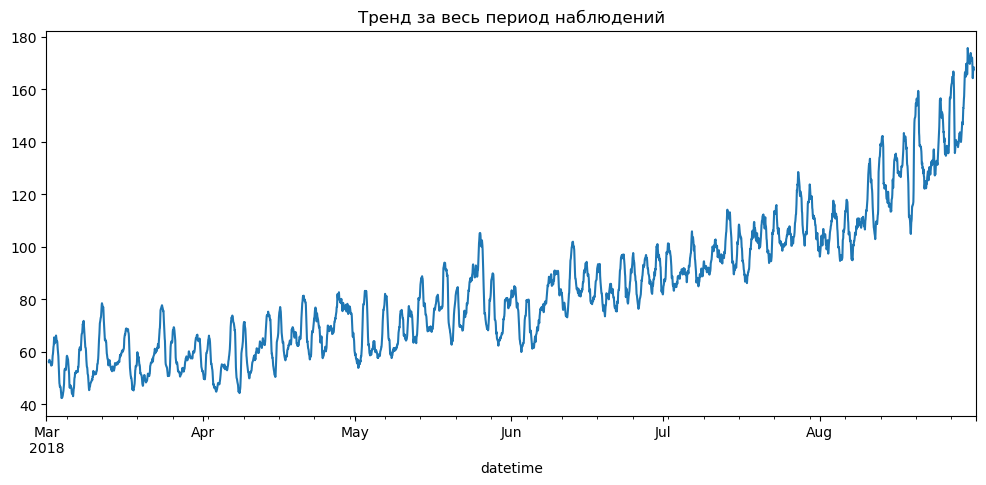

In [7]:
decomposed1 = seasonal_decompose(taxi)
plt.figure(figsize=(12, 5))
plt.title('Тренд за весь период наблюдений')
decomposed1.trend.plot(ax=plt.gca())
plt.show()

Рассмотрим тренд, сезонность и остатки по наблюдениям за последний месяц

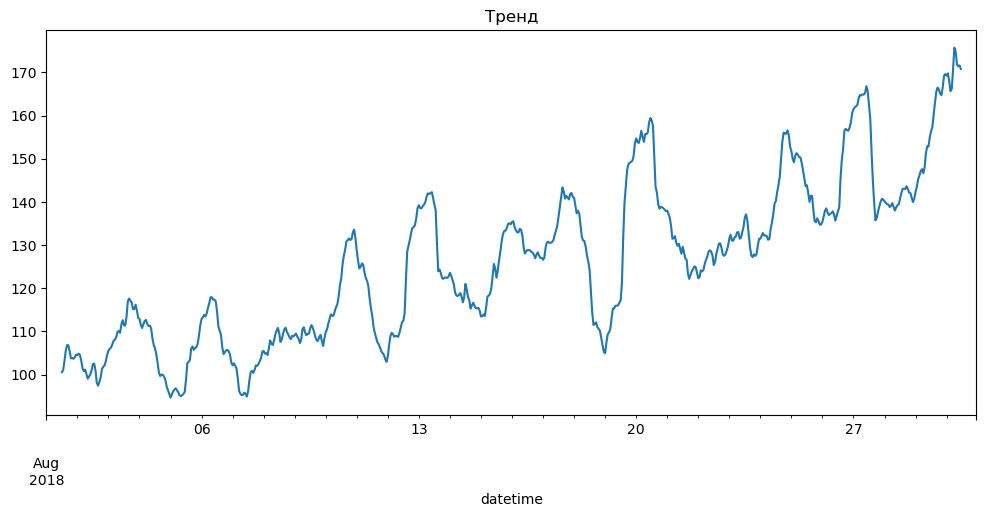

In [8]:
decomposed = seasonal_decompose(taxi['2018-08-01':'2018-08-30'])
plt.figure(figsize=(12, 5))
plt.title('Тренд')
decomposed.trend.plot(ax=plt.gca())
plt.show()

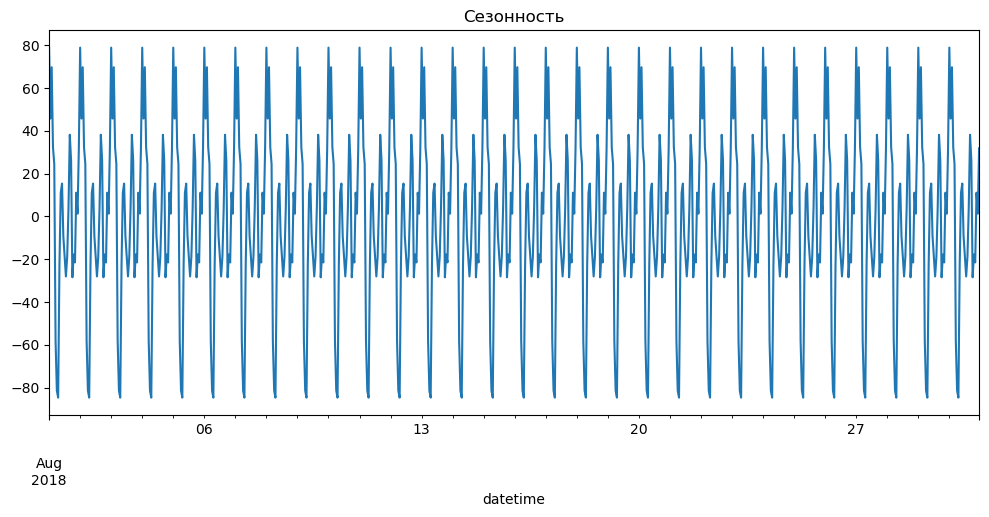

In [9]:
plt.figure(figsize=(12, 5))
plt.title('Сезонность')
decomposed.seasonal.plot(ax=plt.gca())
plt.show()

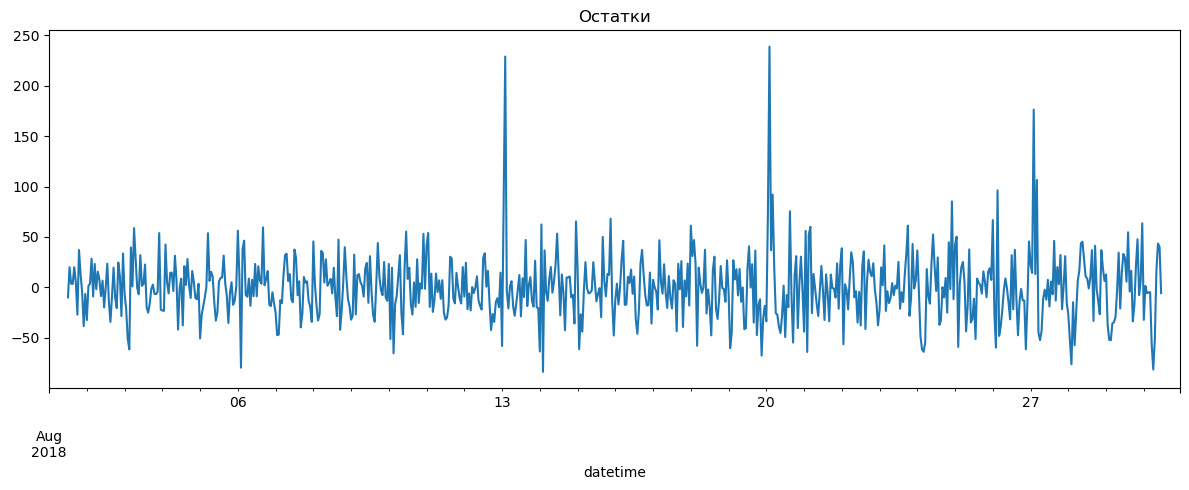

In [10]:
plt.figure(figsize=(12, 5))
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()
plt.show()

Были построены графики тренда, сезонности и остатоков. При рассмотрении графиков наблюдаем, что:
1) Тренд за период всех наблюдений иллюстрирует тенденцию к увеличению количества вызовов  
2) Наблюдается явная сезонность по наблюдениям за последний месяц, что сообщает о стационарости процесса  
3) По остатоком наблюдются периодические скачки, которыми отмечается время в ночь с воскресенья на понедельник (конец выходных) 

### Обучение моделей 

In [11]:
#разделение выборки на тестовую и тренировчную
train, test = train_test_split(taxi, test_size=0.1, shuffle=False)

In [12]:
#Проверка выборок
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [13]:
#прогноз константой
pred_median = np.ones(test.shape) * train['num_orders'].median()  
print("MAE:", mean_absolute_error(test['num_orders'], pred_median))

MAE: 70.7918552036199


In [14]:
#прогноз по предыдущему значениею ряда
pred_previous = test['num_orders'].shift(1).fillna(train['num_orders'].iloc[-1])

print("MAE:", mean_absolute_error(test['num_orders'], pred_previous))

MAE: 44.97285067873303


In [15]:
#добавление столбцов с часом, днём недели, днём и месяцем

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['dayofweek'] = df.index.dayofweek
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [17]:
taxi_feat = make_features(taxi, 20, 40)
display(taxi_feat)

,num_orders,dayofweek,day,hour,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,31,19,8,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,164.150
2018-08-31 20:00:00,154,4,31,20,8,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,162.725
2018-08-31 21:00:00,159,4,31,21,8,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,161.925


In [18]:
taxi_feat = taxi_feat.dropna()

In [19]:
X = taxi_feat.drop('num_orders', axis=1)
y = taxi_feat['num_orders']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

#### Линейная регрессия

In [21]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 10 ms


LinearRegression()

In [22]:
%%time
preds_train = lr.predict(X_train)
print("RMSE на обучающей выборке:", mean_squared_error(y_train, preds_train) ** 0.5)

RMSE на обучающей выборке: 28.966873663447267
CPU times: total: 0 ns
Wall time: 3 ms


In [23]:
tscv = TimeSeriesSplit(n_splits = 4)

In [24]:
#перебор гиперпараметров с помощью gridsearch

parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(lr,parameters, cv=tscv, scoring = 'neg_root_mean_squared_error', verbose=False)
grid.fit(X_train, y_train)
grid.best_params_

{'copy_X': True, 'fit_intercept': False}

In [25]:
%%time
lr_tuned = LinearRegression(**grid.best_params_).fit(X_train, y_train)

CPU times: total: 125 ms
Wall time: 4 ms


In [26]:
%%time
lr_tuned_pred = lr_tuned.predict(X_train)


CPU times: total: 141 ms
Wall time: 3 ms


In [27]:
lr_tuned_rmse = np.sqrt(mse(y_train, lr_tuned_pred))
print(round(lr_tuned_rmse,2)) 

28.97


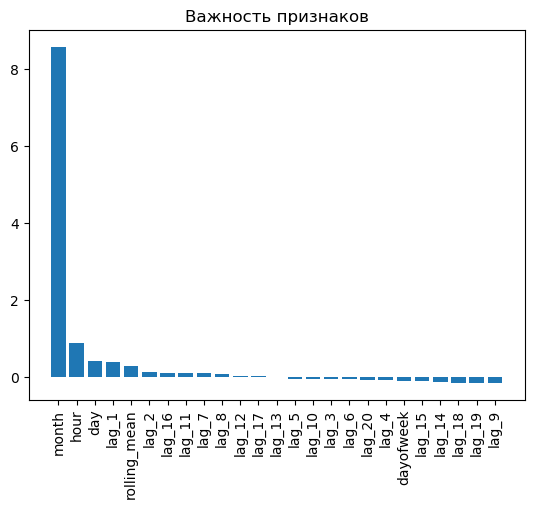

In [28]:
importances1 = pd.DataFrame(data={
        'Attribute': X_train.columns,
        'Importance': lr_tuned.coef_
        })
importances1 = importances1.sort_values(by='Importance', ascending=False)
plt.bar(x=importances1['Attribute'], height=importances1['Importance'])
plt.title('Важность признаков')
plt.xticks(rotation='vertical')
plt.show()

#### LGBM

In [29]:
%%time
train_data = lightgbm.Dataset(X_train, label=y_train, free_raw_data=False)
test_data = lightgbm.Dataset(X_test, label=y_test)

CPU times: total: 0 ns
Wall time: 0 ns


In [30]:
param_grid = {"n_estimators": [100, 200],
              'learning_rate': [0.1, 0.2, 0.4, 0.6],
              'max_depth': [15, 20, 25, 30],
             }

In [31]:
lgbm = lightgbm.LGBMRegressor(n_jobs = 8)

In [32]:
tscv1 = TimeSeriesSplit(n_splits = 4)

In [33]:
grid_search = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = tscv1,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                           error_score='raise')
grid_search.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4123
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 25
[LightGBM] [Info] Start training from score 78.597765


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             error_score='raise', estimator=LGBMRegressor(n_jobs=8), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.4, 0.6],
                         'max_depth': [15, 20, 25, 30],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [34]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}


In [35]:
%%time
lgbm_tuned = lightgbm.LGBMRegressor(**grid_search.best_params_).fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4123
[LightGBM] [Info] Number of data points in the train set: 3938, number of used features: 25
[LightGBM] [Info] Start training from score 78.597765
CPU times: total: 969 ms
Wall time: 218 ms


In [36]:
%%time
lgbm_tuned_pred = lgbm_tuned.predict(X_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 125 ms
Wall time: 8 ms


In [37]:

lgbm_tuned_rmse = np.sqrt(mse(y_train, lgbm_tuned_pred))
print(round(lgbm_tuned_rmse,2))

12.54


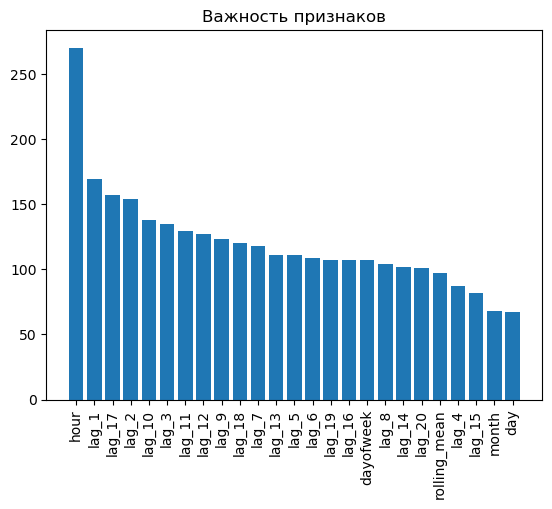

In [38]:
importances2 = pd.DataFrame(data={
        'Attribute': X_train.columns,
        'Importance': lgbm_tuned.feature_importances_
        })
importances2 = importances2.sort_values(by='Importance', ascending=False)
plt.bar(x=importances2['Attribute'], height=importances2['Importance'])
plt.title('Важность признаков')
plt.xticks(rotation='vertical')
plt.show()

### CatBoost

In [39]:
%%time
cb = CatBoostRegressor(logging_level='Silent')
cb.fit(X_train, y_train)

CPU times: total: 31.6 s
Wall time: 3.08 s


In [40]:
param_grid1 ={'iterations': [700],
        'learning_rate': [0.03, 0.1],
        'depth': [3, 6, 8],
        'l2_leaf_reg': [1, 3, 5]                                                                                
              }

In [41]:
tscv2 = TimeSeriesSplit(n_splits = 4)

In [42]:
%%time
grid_search2 = GridSearchCV(estimator = cb, 
                           param_grid = param_grid1, 
                           cv = tscv2,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                           error_score='raise')
grid_search2.fit(X_train, y_train)

CPU times: total: 13.2 s
Wall time: 1min 41s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             error_score='raise',
             estimator=<catboost.core.CatBoostRegressor object at 0x000001730D04AF50>,
             n_jobs=-1,
             param_grid={'depth': [3, 6, 8], 'iterations': [700],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.03, 0.1]},
             scoring='neg_mean_squared_error')

In [43]:
print(grid_search2.best_params_)

{'depth': 3, 'iterations': 700, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [44]:

cb_tuned = CatBoostRegressor(**grid_search2.best_params_).fit(X_train, y_train)

0:	learn: 37.5097776	total: 1.65ms	remaining: 1.15s
1:	learn: 36.3111414	total: 3.34ms	remaining: 1.16s
2:	learn: 35.2451697	total: 4.55ms	remaining: 1.06s
3:	learn: 34.3556445	total: 5.66ms	remaining: 985ms
4:	learn: 33.4057642	total: 6.82ms	remaining: 948ms
5:	learn: 32.8191191	total: 8.21ms	remaining: 949ms
6:	learn: 32.2445462	total: 9.79ms	remaining: 969ms
7:	learn: 31.8305165	total: 11ms	remaining: 950ms
8:	learn: 31.1393677	total: 12.1ms	remaining: 931ms
9:	learn: 30.4989645	total: 13.3ms	remaining: 916ms
10:	learn: 30.0315654	total: 14.7ms	remaining: 920ms
11:	learn: 29.6766040	total: 16.1ms	remaining: 921ms
12:	learn: 29.3600921	total: 17.2ms	remaining: 910ms
13:	learn: 29.0324056	total: 18.4ms	remaining: 900ms
14:	learn: 28.7872057	total: 19.7ms	remaining: 898ms
15:	learn: 28.3174876	total: 21ms	remaining: 898ms
16:	learn: 28.1020366	total: 22.4ms	remaining: 899ms
17:	learn: 27.8935153	total: 23.5ms	remaining: 892ms
18:	learn: 27.6231661	total: 24.7ms	remaining: 886ms
19:	lea

In [45]:
%%time
cb_tuned_preds = cb_tuned.predict(X_train)

CPU times: total: 15.6 ms
Wall time: 3 ms


In [46]:
cb_tuned_rmse = np.sqrt(mse(y_train, cb_tuned_preds))
print(round(cb_tuned_rmse,2))

16.2


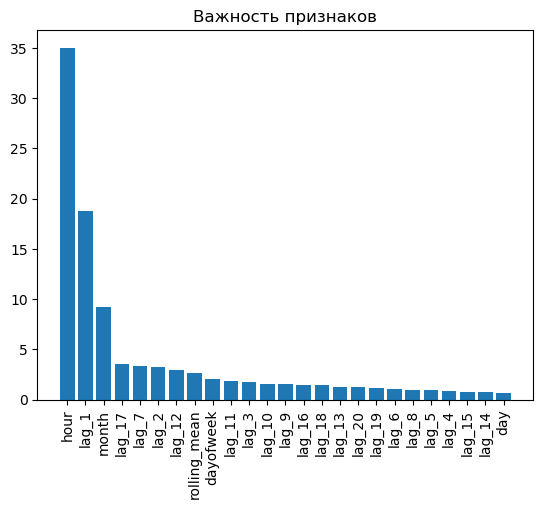

In [47]:
importances3 = pd.DataFrame(data={
        'Attribute': X_train.columns,
        'Importance': cb_tuned.feature_importances_
        })
importances3 = importances3.sort_values(by='Importance', ascending=False)
plt.bar(x=importances3['Attribute'], height=importances3['Importance'])
plt.title('Важность признаков')
plt.xticks(rotation='vertical')
plt.show()

In [53]:
display(lr_tuned_rmse, lgbm_tuned_rmse, cb_tuned_rmse)

28.97137658768804

12.543157832544084

16.204525838254156

На данном этапе мы опробовали три модели с перебором гиперпараметров: LinearRegression, LGBMRegressor и CatBoostRegressor.  
Для каждой из них были вычислены метрики RMSE. Подходящими для анализа модели считаются те, у которых RMSE < 48.  
Метрики RMSE моделей:  
- LinearRegression = 28.97
- LGBMRegressor = 12.54  
- CatBoostRegressor = 16.20  
Все три подходят по критерию из технического задания.  Но наименьшую метрику показа модель LGBMRegressor. 
Далее протестируем её на тестовой выборке.

### Проверка моделей

In [49]:
%%time
final_lgbm_pred = lgbm_tuned.predict(X_test)
rmse_flp = np.sqrt(mse(y_test, final_lgbm_pred))
display(round(rmse_flp,2))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


43.3

CPU times: total: 15.6 ms
Wall time: 5 ms


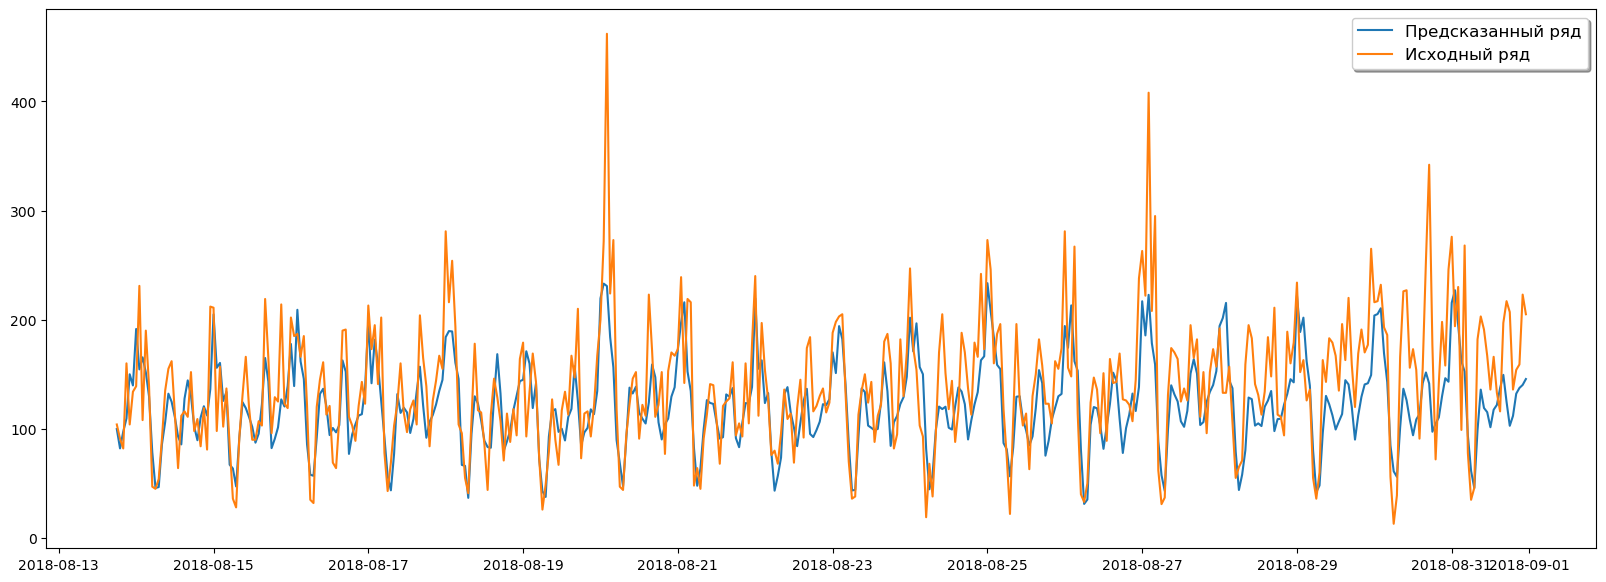

In [50]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(pd.Series(final_lgbm_pred, index = y_test.index), label='Предсказанный ряд')
ax.plot(y_test, label='Исходный ряд')
legend = ax.legend(loc='upper right', shadow=True, fontsize= 12)

In [51]:
#y_test1 = y_test
#y_test1['difference'] = y_test - pd.Series(final_lgbm_pred, index = y_test.index)
#display(y_test1)

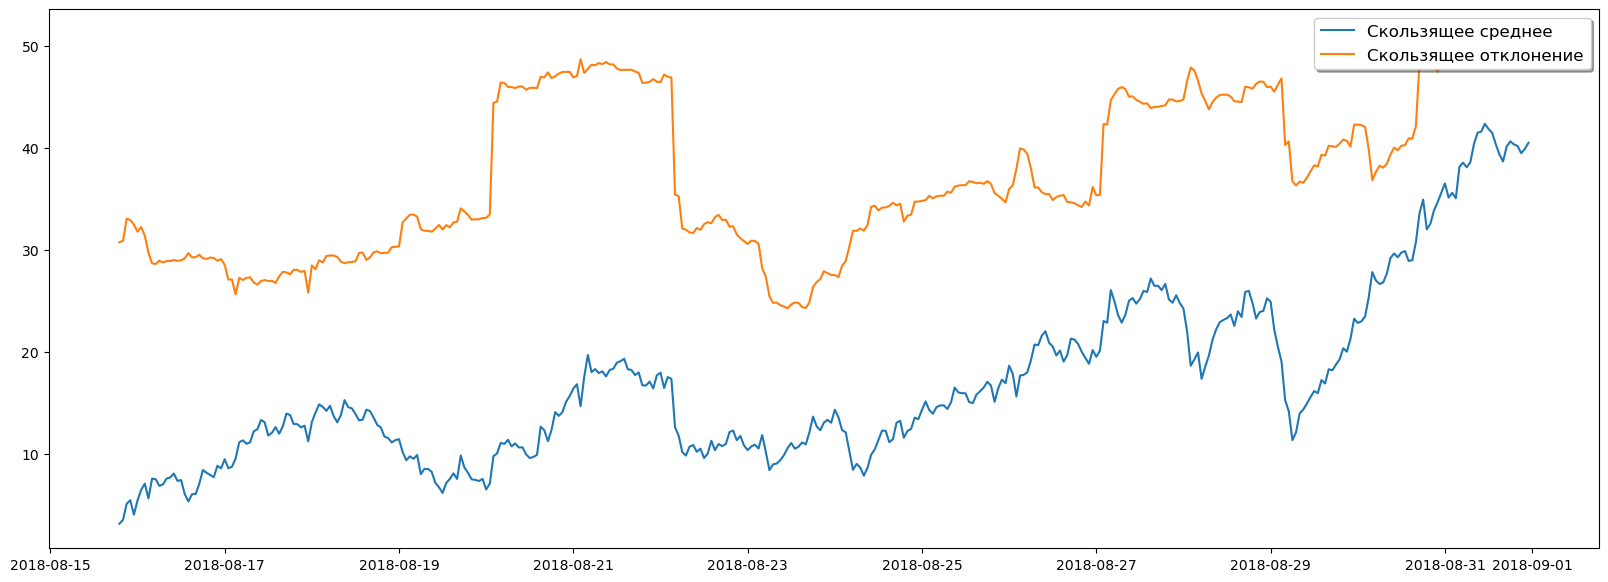

In [52]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot((y_test - pd.Series(final_lgbm_pred, index = y_test.index)).rolling(50).mean(), label='Скользящее среднее')
ax.plot((y_test - pd.Series(final_lgbm_pred, index = y_test.index)).rolling(50).std(), label='Скользящее отклонение')
legend = ax.legend(loc='upper right', shadow=True, fontsize= 12)
plt.show()
#legend = ax.legend(loc='upper right', shadow=True, fontsize= 12)

С помощью модели LGBM были получены предсказания на тестовой выборке.  
Результаты сопоставлены с исходными целевыми значениями и визуализированы на графике.  
По графику видно, что предсказания модели близки к реальным значениям.  
Тем не менее, заметны значительное различия этих показателей:  
    1) Модель не оказалась способной предсказать периоды аномального пика заказов такси (конец выходных дней)    
    2) Скользящее среднее демонстрирует рост с течением времени, что сообщает о растущей разности предсказаний и исходных данных   
    3) Также с течением времени стали заметна рост скользящего стандартного отклонения. Скачки этого показателя сообщают о большом разбросе данных в этот промежуток времени. 
Можем предположить, что способность модели корректно предсказывать количество заказов связанно с постоянно возрастающим в течение года спросом на такси.   
Для того, чтобы модель могла лучше прогнозировать часы пик, необходимо количество данных, собранных за больший период чем полгода.  


### Итоги работы

В ходе работы были предприняты следующие шаги:
1) Данные были загружены - в исходной таблице 26496 записей с данными о заказах такси, разбитые по 10 минут.  
Данные были ресемплированы по часу - в итоговой таблице стало 4416 записей.
2) Анализ данных: были построены графики тренда, сезонности и остатоков. 
    При рассмотрении графиков наблюдаем, что:
- Тренд за период всех наблюдений иллюстрирует тенденцию к увеличению количества вызовов    
- Наблюдается явная сезонность по наблюдениям за последний месяц, что сообщает о стационарости процесса    
- По остатоком наблюдются периодические скачки, которыми отмечается время в ночь с воскресенья на понедельник (конец выходных)   
3) На тренировочной выборке были обучены 3 модели с различными гиперпараметрами: LinearRegression, LGBMRegressor и CatBoostRegressor    
    Для принятия оценки качества предсказания моделей для каждой из них была вычеслена метрика RMSE и пременено условие RMSE < 48  
    Получили следующие показатели:   
        - LinearRegression = 28.97  
        - LGBMRegressor = 12.54    
        - CatBoostRegressor = 16.20    
Все три подходят по критерию из технического задания.  Но наилучшую метрику показала модель LGBMRegressor 
с гиперпараметрами 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100. 

4) Модель LGBMRegressor была протестирована на тестовой выборке. Метрика RMSE = 43.3.  
Были построены графики для демонстрации сводимости предсказаний модели к исходным тестовым данным.     
По графику видно, что предсказания модели близки к реальным значениям.  
Тем не менее, заметны значительное различия этих показателей:  
    1) Модель не оказалась способной предсказать периоды аномального пика заказов такси (конец выходных дней)    
    2) Скользящее среднее демонстрирует рост с течением времени, что сообщает о растущей разности предсказаний и исходных данных 
    3) Также с течением времени стали заметна рост скользящего стандартного отклонения. Скачки этого показателя сообщают о большом разбросе данных в этот промежуток времени. 

5) Итоги работы:
При обзоре работы модели, можно сказать, что она хорошо справляется с ежедневно повторяющимися явлениями, но не способна предсказать аномальный спрос.  
Можем предположить, что способность модели корректно предсказывать количество заказов связанно с постоянно возрастающим в течение года спросом на такси.   
Для того, чтобы модель могла лучше прогнозировать часы пик, необходимо количество данных, собранных за больший период, чем полгода.  
